In [1]:
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, count, lit, min, max, mean, stddev
from pyspark.sql.functions import monotonically_increasing_id

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.classification import LinearSVC

import warnings
warnings.filterwarnings("ignore")  # Ignore warnings coming from Arrow optimizations.
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

from cdc_module import plot_models_results
from training_module import *



%matplotlib inline

# **5.Machine Learning Algorithms**

In [2]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("CDC Diabetes Health Indicators") \
    .master('spark://13.61.7.51:7077') \
    .config("spark.driver.memory", "160g")\
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [3]:
# read X_explained_variance_components.csv
X_explained_variance_components = spark.read.csv('./X_explained_variance_components.csv', header=True, inferSchema=True)

# read X_elbow_method_components.csv
X_elbow_method_components = spark.read.csv('./X_elbow_method_components.csv', header=True, inferSchema=True)

# read X_no_compound_features.csv
X_no_compound_features = spark.read.csv('./X_no_compound_features.csv', header=True, inferSchema=True)

# read y_pyspark.csv
y_pyspark = spark.read.csv('./y_pyspark.csv', header=True, inferSchema=True)

## 5.1 Tuning Hyperparameters

In [4]:
datasets = {}
datasets['explained_variance'] = test_train_split(X_explained_variance_components, y_pyspark)
datasets['elbow_method'] = test_train_split(X_elbow_method_components, y_pyspark)
datasets['no_compound_features'] = test_train_split(X_no_compound_features, y_pyspark)

In [5]:
models = {}

In [6]:
models['lr'] = LogisticRegression(
    featuresCol="features",          
    labelCol="Diabetes_binary",      
    regParam=0.1,                    
    elasticNetParam=0.0,             
    family="binomial",               
    maxIter=500                     
)
models['dt'] = DecisionTreeClassifier(labelCol="Diabetes_binary", featuresCol="features", maxDepth=5, minInstancesPerNode=2)
models['rf'] = RandomForestClassifier(labelCol="Diabetes_binary", featuresCol="features", maxDepth=10, minInstancesPerNode=5, numTrees=100)
models['gbt'] = GBTClassifier(labelCol="Diabetes_binary", featuresCol="features", maxDepth=5, maxIter=50, stepSize=0.1)
models['nb'] = NaiveBayes(labelCol="Diabetes_binary", featuresCol="features")
models['svm'] = LinearSVC(labelCol="Diabetes_binary", featuresCol="features")
models['mlp'] = MultilayerPerceptronClassifier(labelCol="Diabetes_binary", featuresCol="features", layers=[10,100,2], seed=1234, stepSize=0.01)

In [7]:
param_grids = {
    'lr': (ParamGridBuilder()
           .addGrid(models['lr'].regParam, [0.01, 0.1, 0.5])
           .addGrid(models['lr'].maxIter, [500, 1000, 2000])
           .build()),
    
    'dt': (ParamGridBuilder()
           .addGrid(models['dt'].maxDepth, [5, 10, 15])
           .addGrid(models['dt'].minInstancesPerNode, [2, 5])
           .build()),
    
    'rf': (ParamGridBuilder()
           .addGrid(models['rf'].maxDepth, [5, 10, 15])
           .addGrid(models['rf'].numTrees, [5, 10, 50])
           .build()),
    
    'gbt': (ParamGridBuilder()
            .addGrid(models['gbt'].maxDepth, [3, 5, 8])
            .addGrid(models['gbt'].maxIter, [50, 100])
            .build()),
    
    'nb': (ParamGridBuilder()
           .addGrid(models['nb'].smoothing, [0.1, 1.0, 10.0])
           .build()),
    
    'svm': (ParamGridBuilder()
            .addGrid(models['svm'].regParam, [0.01, 0.1, 1.0])
            .build()),
    
    'mlp': (ParamGridBuilder()
            .addGrid(models['mlp'].layers, [[10, 100, 2], [13, 100, 2], [10, 25, 25, 2]])
            .addGrid(models['mlp'].stepSize, [0.001, 0.01])
            .build())
}

models_name_mapping = {
    'lr': 'Logistic Regression', 
    'dt': 'Decision Tree Classifier', 
    'rf': 'Random Forest Classifier', 
    'gbt': 'Gradient-Boosted Tree Classifier', 
    'nb': 'Naive Bayes Classifier', 
    'svm': 'Linear Support Vector Machine (SVM)', 
    'mlp': 'Multilayer Perceptron Classifier'
}



In [8]:
for dataset_name, dataset in datasets.items():
    for model_name, model in models.items():
        tune_hyperparameters(dataset_name, dataset, model_name, model, models_name_mapping, param_grids, 'results_cross_validation.json')


Training model Logistic Regression on dataset explained_variance
Accuracy:0.8542711347721399,
        Precision:0.5517241379310345,
        Recall:0.08590604026845637,
        F1 Score:0.148664343786295,
        Time:1015.108492136001587seconds
        Best Hyperparameters:{'maxIter': 1000, 'regParam': 0.1}


Training model Decision Tree Classifier on dataset explained_variance
Accuracy:0.8549117497625307,
        Precision:0.5763656633221851,
        Recall:0.07710663683818046,
        F1 Score:0.13601683767429623,
        Time:623.147879123687744seconds
        Best Hyperparameters:{'maxDepth': 5, 'minInstancesPerNode': 2}


Training model Random Forest Classifier on dataset explained_variance
Accuracy:0.8556849057854161,
        Precision:0.6128608923884514,
        Recall:0.06964951528709917,
        F1 Score:0.12508370162046337,
        Time:465.572850942611694seconds
        Best Hyperparameters:{'maxDepth': 10, 'numTrees': 50}


Training model Gradient-Boosted Tree Classifier o

## 5.3. Plotting Results

In [9]:
results = read_results('./results_cross_validation.json')

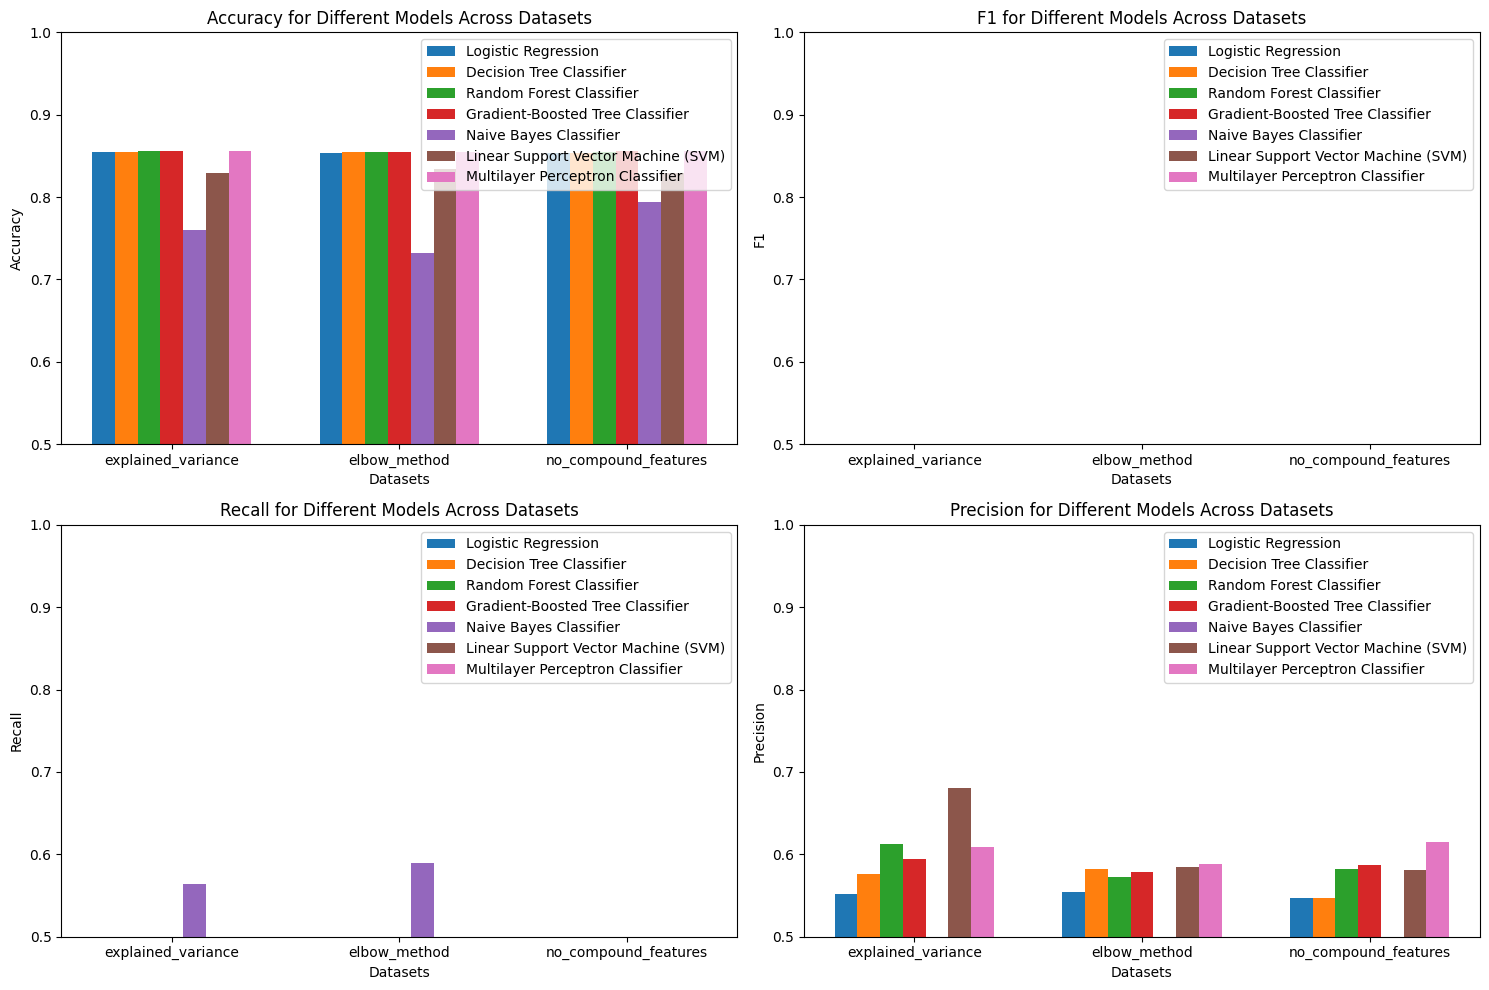

In [10]:
plot_models_results(results, models_name_mapping)